# Compare NIST20-only with NEIMS generated spektra
- NIST20-only spectra (+NEIMS test set) were not used for training NEIMS
- we want to reveal the influence of derivatization on NEIMS performance

In [1]:
# copied imports, maybe filter later
import numpy as np
from tqdm import tqdm
from matchms.importing import load_from_msp
from matchms.exporting import save_as_msp
from matchms.filtering import normalize_intensities
from matchms import Spectrum, calculate_scores
from matchms.similarity import CosineGreedy
from spectra_process_utils import process_neims_spec

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from rdkit.Chem import PandasTools
from pandas import DataFrame as df
from rdkit import Chem
from rdkit.Chem.inchi import MolToInchiKey

import os
import spectrum_utils.plot as sup
import spectrum_utils.spectrum as sus
from collections import Counter
import random
from argparse import ArgumentError

## Find the NIST20-only data (can be skipped and loaded below)
- load NIST20
- clean it from spektra not containing smiles
- extract NIST20-only spectra


.<br>


#### PROBLEMS with NIST:
- some spectra don't have a unique identificator (60497 have no smiles or no inchikey) -> 290121 somehow useful spectra
- some of the smiles are not valid according to rdkit (-> 290063 useful spectra)
------------------------------------------------------------------------------------------------
#### Statistics
- NEIMS-train+valid ... 248707 canon valid SMILES / spectra
- NIST clean        ... 290062 canon valid SMILES / spectra (243330 of them unique)
- num of unique SMILES that are in NIST clean and are not in the NEIMS-train+valid: 60996 valid SMILES
- !!! num of unique SMILES that are in NEIMS-train+valid and are not in the NIST clean: 66368
- ??? final len of NIST20-only: 86772 spectra

In [2]:
from rdkit import RDLogger 
RDLogger.DisableLog('rdApp.*') 

In [3]:
%%time
# load NIST20
nist_path = "data/NIST/NIST_20/20210925_NIST_EI_MS_cleaned.msp"
nist = [*load_from_msp(nist_path, metadata_harmonization=False)]

CPU times: user 2min 16s, sys: 1.12 s, total: 2min 17s
Wall time: 2min 17s


In [4]:
print("len NIST:", len(nist))
nist[111800].metadata

len NIST: 350618


{'formula': 'C17H10O',
 'mw': '230',
 'casno': '3029-19-4',
 'id': '111818',
 'comment': 'StdNP=2432 ; NIST MS# 155472, Seq# R38951 |RI:2285|',
 'inchi': 'InChI=1S/C17H10O/c18-10-14-7-6-13-5-4-11-2-1-3-12-8-9-15(14)17(13)16(11)12/h1-10H',
 'inchikey': 'RCYFOPUXRMOLQM-UHFFFAOYSA-N',
 'iupac_name': 'pyrene-1-carbaldehyde',
 'smiles': 'C1=CC2=C3C(=C1)C=CC4=C(C=CC(=C43)C=C2)C=O',
 'num_peaks': '117',
 'compound_name': '1-Pyrenecarboxaldehyde',
 'retention_index': '2285'}

In [15]:
# filter datapoints with no smiles or inchikey (60163 out)
# AND CANONIZE THE SMILES
clean_nist = []
corrupted_indexes = []
corrupted_formulas = []
corrupted_specrta = []
num_of_stereo_before_can = 0 ###################################################
num_of_stereo_after_can = 0 ###################################################
for i in tqdm(range(len(nist))):
#     num_of_stereo_before_can += 1 if "@" in nist[i].metadata["smiles"] else num_of_stereo_before_can ###################################################
    try: 
        nist[i].metadata["smiles"]
        nist[i].metadata["inchikey"]
        
        if "@" in nist[i].metadata["smiles"]: ###########################################
            num_of_stereo_before_can += 1 ###################################################
#         canonize SMILES and update Spectrum
        meta = nist[i].metadata
        can_smiles = Chem.MolToSmiles(Chem.MolFromSmiles(meta["smiles"]),True)
        if "@" in can_smiles: #######################################################
            num_of_stereo_after_can += 1 ####################################################
        meta["smiles"] = can_smiles
        s = Spectrum(mz=nist[i].mz, intensities=nist[i].intensities, metadata=meta, metadata_harmonization=False)
        clean_nist.append(s)
    except Exception as e:
        corrupted_indexes.append(nist[i].metadata["id"])
        corrupted_formulas.append(nist[i].metadata["formula"])
        corrupted_specrta.append(nist[i])

100%|██████████| 350618/350618 [02:24<00:00, 2422.48it/s]


In [16]:
# test smaz
print(f"from {len(corrupted_formulas)} corrupted spektra we have {len(set(corrupted_formulas))} unique formulas")
print(f"the number of stereochemicals before canonization: {num_of_stereo_before_can} and after: {num_of_stereo_after_can}")

from 60556 corrupted spektra we have 28310 unique formulas
the number of stereochemicals before canonization: 432 and after: 432


In [53]:
# collect SMILES of NEIMS train+valid
neims_train_smiles = []
for t in ["train", "validation"]: 
    with open (f"../NEIMS/training_splits/{t}_set_smiles.txt", "r") as f:
        lines = f.read().splitlines()
        neims_train_smiles += lines
neims_train_smiles = np.array(neims_train_smiles)

In [ ]:
%%time
clean_nist_smiles_cans = [s.metadata["smiles"] for s in tqdm(clean_nist)]

In [ ]:
%%time
# canonicalize NEIMS train smiles
neims_train_smiles_cans = [Chem.MolToSmiles(Chem.MolFromSmiles(smi),True) for smi in tqdm(neims_train_smiles)]

In [13]:
%%time
nist20only_smiles_cans = set(clean_nist_smiles_cans) - set(neims_train_smiles_cans)
nist20only = [s for s in tqdm(clean_nist) if s.metadata["smiles"] in nist20only_smiles_cans]

100%|██████████| 290062/290062 [00:14<00:00, 20640.82it/s]

CPU times: user 14.6 s, sys: 437 ms, total: 15.1 s
Wall time: 15 s


In [56]:
len(nist20only)

86772

### Save NIST20-only

In [57]:
%%time
# carefully, doesn't create new file, adds to existing one!!!!
# save_as_msp(spectrums=nist20only, filename="data/NIST/NIST_20only/NIST20_only.msp")

CPU times: user 23.3 s, sys: 224 ms, total: 23.6 s
Wall time: 24.4 s


# -------------------------------------------------------------------------------------------------

### Try to repair spectra
Pair corrupted spectra to part of NEIMS train+val SIMLES that don't have SMILES counterpart in NIST

- create formulas for NEIMS-only SMILES
- create a dictionary - keys are the unique corrupted_formulas
                      - values are lists of corresponding SMILES from NIEMS only

In [ ]:
# TBA

### Load NIST20-only

In [3]:
%%time
# load NIST20-only 
nist20only_path = "data/NIST/NIST_20only/NIST20_only.msp"
nist20only = list(load_from_msp(nist20only_path, metadata_harmonization=False))

CPU times: user 42.6 s, sys: 535 ms, total: 43.1 s
Wall time: 43.1 s


In [4]:
len(nist20only)

86772

## Split NIST20-only to deriv and nonderiv

In [5]:
def is_derivatized(mol=None,smiles=None):
    if mol is None:
        mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)

    return mol.HasSubstructMatch(tms_match) or mol.HasSubstructMatch(meox_match_co) or mol.HasSubstructMatch(meox_match_cho)

# deriv mol pieces
tms = '[Si]([CH3])([CH3])[CH3]'
tms_match = Chem.MolFromSmarts('*~[O,N,S]' + tms)
tms_match0 = Chem.MolFromSmarts('[#0]([CH3])([CH3])[CH3]')
meox_match_co = Chem.MolFromSmarts('C([C,c])([C,c])=NO[CH3]')
meox_match_cho = Chem.MolFromSmarts('[CH]([C,c])=NO[CH3]')
meox_match0 = Chem.MolFromSmarts('[#0]=NO[CH3]')
co = Chem.MolFromSmiles('C=O')

In [6]:
# split to driv and nonderiv
isder = [] # list of length len(nist20only) that stores for every posiiton whether the corresponding spektra is or is not derivatized
for s in tqdm(nist20only):
#     print(s.metadata["smiles"])
    isder += [is_derivatized(smiles=s.metadata["smiles"])]

  0%|          | 0/86772 [00:00<?, ?it/s][23:27:04] WARNING: not removing hydrogen atom without neighbors
[23:27:04] WARNING: not removing hydrogen atom without neighbors
 19%|█▉        | 16414/86772 [00:02<00:12, 5824.25it/s][23:27:06] WARNING: not removing hydrogen atom without neighbors
[23:27:06] WARNING: not removing hydrogen atom without neighbors
[23:27:06] WARNING: not removing hydrogen atom without neighbors
 32%|███▏      | 27740/86772 [00:04<00:10, 5678.41it/s][23:27:08] WARNING: not removing hydrogen atom without neighbors
[23:27:08] WARNING: not removing hydrogen atom without neighbors
 34%|███▍      | 29405/86772 [00:04<00:11, 5118.03it/s][23:27:09] WARNING: not removing hydrogen atom without neighbors
[23:27:09] WARNING: not removing hydrogen atom without neighbors
[23:27:09] WARNING: not removing hydrogen atom without neighbors
 39%|███▉      | 33855/86772 [00:05<00:10, 4813.14it/s][23:27:10] WARNING: not removing hydrogen atom without neighbors
[23:27:10] WARNING: not 

In [7]:
print("len deriv:", sum(isder))
print("len nonderiv:", len(nist20only)-sum(isder))

len deriv: 3296
len nonderiv: 83476


## Prepare df with NEIMS generated spectra and NIST spectra
- create df with mols -> sdf
- enrich the sdf with NEIMS
- create Spectra again
- appednd NIST spectra to the dataset 
- with nist_ids assert tht you matched correct spectra together
- add a isder(ivatized) flag to each spectra pair

In [8]:
# prepare NEIMS sdf and compose a command for NEIMS generation 
sdf_before = "/storage/brno2/home/ahajek/Spektro/MassGenie/tmp/tmp_for_NEIMS.sdf"
sdf_after = "/storage/brno2/home/ahajek/Spektro/MassGenie/tmp/tmp_for_NEIMS_enriched.sdf"

df_neims_plain = pd.DataFrame({"nist_id": [s.metadata["id"] for s in nist20only],
                             "smiles": [s.metadata["smiles"] for s in nist20only]})
PandasTools.AddMoleculeColumnToFrame(df_neims_plain, smilesCol='smiles', molCol='ROMol')
PandasTools.WriteSDF(df_neims_plain, sdf_before, idName="nist_id", properties=list(df_neims_plain.columns))

print(f"now run in terminal:\n###############\nconda activate NEIMSpy2 && bash ~/Spektro/NEIMS/run_make_spectra_prediction.sh {sdf_before} {sdf_after} && conda deactivate\n###############\n")

[23:27:34] WARNING: not removing hydrogen atom without neighbors
[23:27:34] WARNING: not removing hydrogen atom without neighbors
[23:27:34] WARNING: not removing hydrogen atom without neighbors
[23:27:34] WARNING: not removing hydrogen atom without neighbors
[23:27:34] WARNING: not removing hydrogen atom without neighbors
[23:27:34] WARNING: not removing hydrogen atom without neighbors
[23:27:34] WARNING: not removing hydrogen atom without neighbors
[23:27:35] WARNING: not removing hydrogen atom without neighbors
[23:27:35] WARNING: not removing hydrogen atom without neighbors
[23:27:35] WARNING: not removing hydrogen atom without neighbors
[23:27:35] WARNING: not removing hydrogen atom without neighbors
[23:27:35] WARNING: not removing hydrogen atom without neighbors
[23:27:35] WARNING: not removing hydrogen atom without neighbors
[23:27:35] WARNING: not removing hydrogen atom without neighbors
[23:27:35] WARNING: not removing hydrogen atom without neighbors
[23:27:35] WARNING: not r

now run in terminal:
###############
conda activate NEIMSpy2 && bash ~/Spektro/NEIMS/run_make_spectra_prediction.sh /storage/brno2/home/ahajek/Spektro/MassGenie/tmp/tmp_for_NEIMS.sdf /storage/brno2/home/ahajek/Spektro/MassGenie/tmp/tmp_for_NEIMS_enriched.sdf && conda deactivate
###############



In [21]:
df_neims_enriched = PandasTools.LoadSDF(sdf_after, idName="nist_id", smilesName='smiles', molColName='ROMol')

[23:40:30] WARNING: not removing hydrogen atom without neighbors
[23:40:30] WARNING: not removing hydrogen atom without neighbors
[23:40:31] WARNING: not removing hydrogen atom without neighbors
[23:40:37] WARNING: not removing hydrogen atom without neighbors
[23:40:37] WARNING: not removing hydrogen atom without neighbors
[23:40:37] WARNING: not removing hydrogen atom without neighbors
[23:40:37] WARNING: not removing hydrogen atom without neighbors
[23:40:39] WARNING: not removing hydrogen atom without neighbors
[23:40:40] WARNING: not removing hydrogen atom without neighbors
[23:40:42] WARNING: not removing hydrogen atom without neighbors
[23:40:42] WARNING: not removing hydrogen atom without neighbors
[23:40:43] WARNING: not removing hydrogen atom without neighbors
[23:40:43] WARNING: not removing hydrogen atom without neighbors
[23:40:44] WARNING: not removing hydrogen atom without neighbors
[23:40:44] WARNING: not removing hydrogen atom without neighbors
[23:40:44] WARNING: not r

In [33]:
neims_spec = [process_neims_spec(row[1]["PREDICTED SPECTRUM"], 
                                 metadata={"smiles": row[1].smiles,
                                           "id": row[1].nist_id}) 
                  for row in df_neims_enriched.iterrows()]

df_neims_enriched["NEIMS_spec"] = neims_spec
df_neims_enriched.drop(columns=["PREDICTED SPECTRUM"], inplace=True)
df_neims_enriched.nist_id = df_neims_enriched.nist_id.astype(np.int32)

In [34]:
# add NIST SPECTRA 
nist_id2 = [int(s.metadata["id"]) for s in nist20only]
df_neims_enriched["nist_id2"] = nist_id2
df_neims_enriched["isder"] = isder
df_neims_enriched["NIST_spec"] = nist20only

assert (df_neims_enriched.nist_id.astype(int) == df_neims_enriched.nist_id2).all()
df_neims_enriched.drop(columns=["nist_id2"], inplace=True)

,smiles,nist_id,ROMol,NEIMS_spec,isder,NIST_spec
0,[HH],1,,<matchms.Spectrum.Spectrum object at 0x15540b0...,False,<matchms.Spectrum.Spectrum object at 0x15545cc...
1,[HH],2,,<matchms.Spectrum.Spectrum object at 0x15540b0...,False,<matchms.Spectrum.Spectrum object at 0x1554282...
2,B#B,14,,<matchms.Spectrum.Spectrum object at 0x155415e...,False,<matchms.Spectrum.Spectrum object at 0x155425e...
3,C=C,15,,<matchms.Spectrum.Spectrum object at 0x15540b0...,False,<matchms.Spectrum.Spectrum object at 0x155425e...
4,C=C,16,,<matchms.Spectrum.Spectrum object at 0x155415e...,False,<matchms.Spectrum.Spectrum object at 0x155425e...
...,...,...,...,...,...,...
86761,FC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F...,350625,,<matchms.Spectrum.Spectrum object at 0x1553ffb...,False,<matchms.Spectrum.Spectrum object at 0x1554180...
86764,CCC1=C(CC)c2cc3[n-]c(c(C=Cc4c5nc(cc6[n-]c(cc7n...,350628,,<matchms.Spectrum.Spectrum object at 0x1553ffb...,False,<matchms.Spectrum.Spectrum object at 0x1554180...
86765,CCC1=C(CC)c2cc3[n-]c(c(CCc4c5nc(cc6[n-]c(cc7nc...,350629,,<matchms.Spectrum.Spectrum object at 0x1553ffb...,False,<matchms.Spectrum.Spectrum object at 0x1554180...
86767,CCC(C)C1NC(=O)C(NC(=O)c2c3nc4c(C(=O)NC5C(=O)NC...,350633,,<matchms.Spectrum.Spectrum object at 0x1553ffb...,False,<matchms.Spectrum.Spectrum object at 0x1554180...

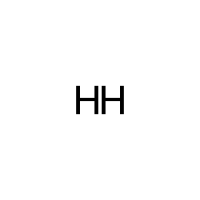
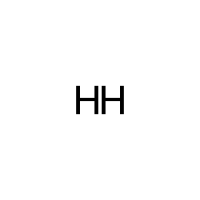
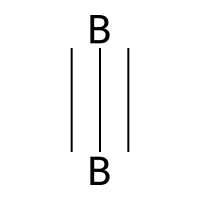
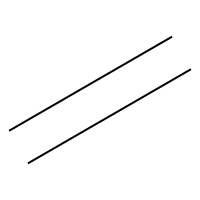
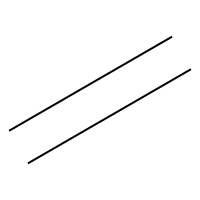
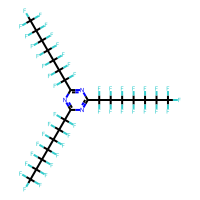
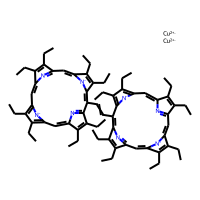
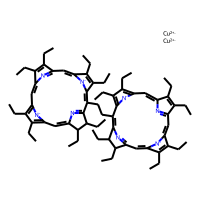
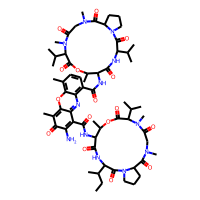
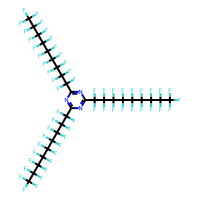

In [35]:
df_neims_enriched[df_neims_enriched.isder == False]

### Save NIST20-only-NEIMS spectra
- first fill the metadata

In [59]:
len(neims_spec)

86772

In [60]:
%%time
# carefully, doesn't create new file, adds to existing one!!!!
# save_as_msp(spectrums=neims_spec, filename="data/NIST/NIST_20only/NIST20_only_NEIMS.msp")

CPU times: user 15.9 s, sys: 244 ms, total: 16.2 s
Wall time: 17.7 s


In [37]:
df_all = df_neims_enriched

## Compute cosine similarity for spectra pairs

In [38]:
%%time
cos_greedy = CosineGreedy()
scores = [cos_greedy.pair(row[1].NEIMS_spec, 
                          row[1].NIST_spec)
                           for row in tqdm(df_all.iterrows())]

86772it [00:20, 4315.39it/s]


CPU times: user 19.7 s, sys: 384 ms, total: 20 s
Wall time: 20.2 s


In [39]:
simils = [score["score"] for score in tqdm(scores)]
matched_peaks = [score["matches"] for score in tqdm(scores)]

100%|██████████| 86772/86772 [00:00<00:00, 2682519.47it/s]


In [40]:
df_all["simils"] = simils
df_all["matched_peaks"] = matched_peaks

,smiles,nist_id,ROMol,NEIMS_spec,isder,NIST_spec,simils,matched_peaks
0,[HH],1,,<matchms.Spectrum.Spectrum object at 0x15540b0...,False,<matchms.Spectrum.Spectrum object at 0x15545cc...,0.0,0
1,[HH],2,,<matchms.Spectrum.Spectrum object at 0x15540b0...,False,<matchms.Spectrum.Spectrum object at 0x1554282...,0.9998874439185594,1
2,B#B,14,,<matchms.Spectrum.Spectrum object at 0x155415e...,False,<matchms.Spectrum.Spectrum object at 0x155425e...,0.23418491397764177,1
3,C=C,15,,<matchms.Spectrum.Spectrum object at 0x15540b0...,False,<matchms.Spectrum.Spectrum object at 0x155425e...,0.9364290373753269,7
4,C=C,16,,<matchms.Spectrum.Spectrum object at 0x155415e...,False,<matchms.Spectrum.Spectrum object at 0x155425e...,0.9186332553499899,7
...,...,...,...,...,...,...,...,...
86767,CCC(C)C1NC(=O)C(NC(=O)c2c3nc4c(C(=O)NC5C(=O)NC...,350633,,<matchms.Spectrum.Spectrum object at 0x1553ffb...,False,<matchms.Spectrum.Spectrum object at 0x1554180...,0.794156922693545,195
86768,C[Si](C)(C)OCC1OC(Oc2cc(O[Si](C)(C)C)c3c(=O)c(...,350639,,<matchms.Spectrum.Spectrum object at 0x1553ffb...,True,<matchms.Spectrum.Spectrum object at 0x1554180...,0.7002754215691137,7
86769,C[Si](C)(C)OCC(O[Si](C)(C)C)C(OC1OC(CO[Si](C)(...,350640,,<matchms.Spectrum.Spectrum object at 0x1553ffb...,True,<matchms.Spectrum.Spectrum object at 0x1554180...,0.8794285304277638,93
86770,FC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F...,350641,,<matchms.Spectrum.Spectrum object at 0x1553ffb...,False,<matchms.Spectrum.Spectrum object at 0x1554180...,0.41371426358154245,57

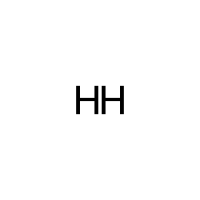
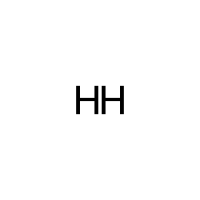
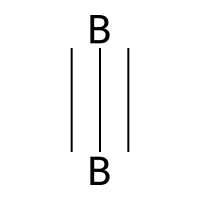
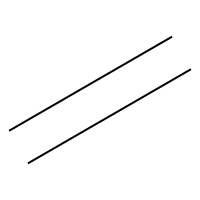
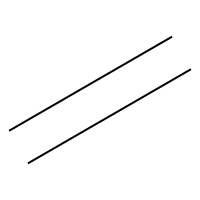
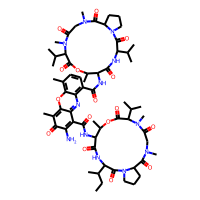
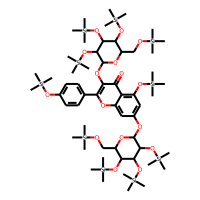
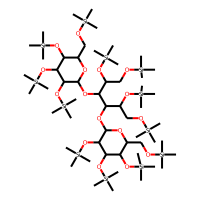
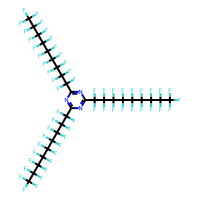
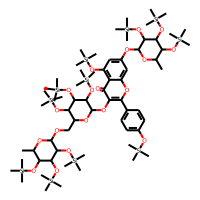

In [41]:
df_all

# Statistics

### All spectra

In [42]:
# mean similarity over all spectra
print(f"mean similarity over all spectra is: {df_all.simils.mean()}")
print(f"mean SMILES len over all spectra is: {df_all.smiles.str.len().mean()}")
print(f"mean matched peaks over all spectra is: {df_all.matched_peaks.mean()}")

mean similarity over all spectra is: 0.7564372271248946
mean SMILES len over all spectra is: 30.764370995251923
mean matched peaks over all spectra is: 87.69867007790532


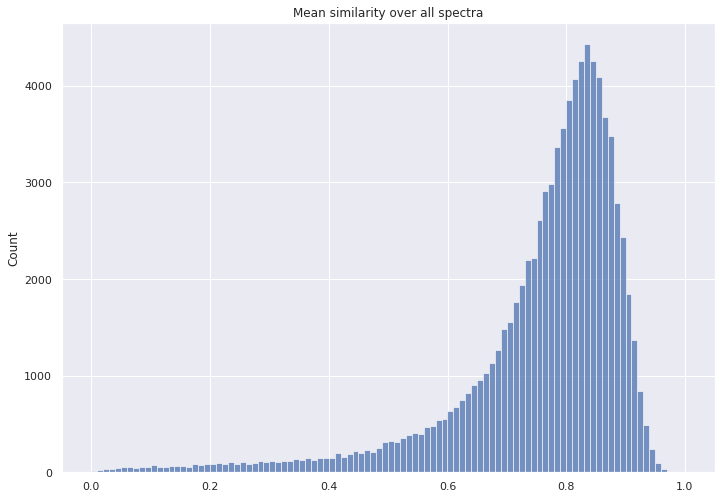

In [43]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
histplot = sns.histplot(df_all.simils.to_numpy(dtype=float), bins=100).set_title("Mean similarity over all spectra")
fig = histplot.get_figure()


### Nonderivatized spectra

In [45]:
# mean similarity over deriv spectra
df_nonderiv = df_all[df_all.isder == False]
print(f"mean similarity over {len(df_nonderiv)} nonderiv spectra is: {df_nonderiv.simils.mean()}")
print(f"mean SMILES len over all spectra is: {df_nonderiv.smiles.str.len().mean()}")
print(f"mean matched peaks over all spectra is: {df_nonderiv.matched_peaks.mean()}")

mean similarity over 83476 nonderiv spectra is: 0.7556592184250633
mean SMILES len over all spectra is: 30.03220087210695
mean matched peaks over all spectra is: 86.25966744932676


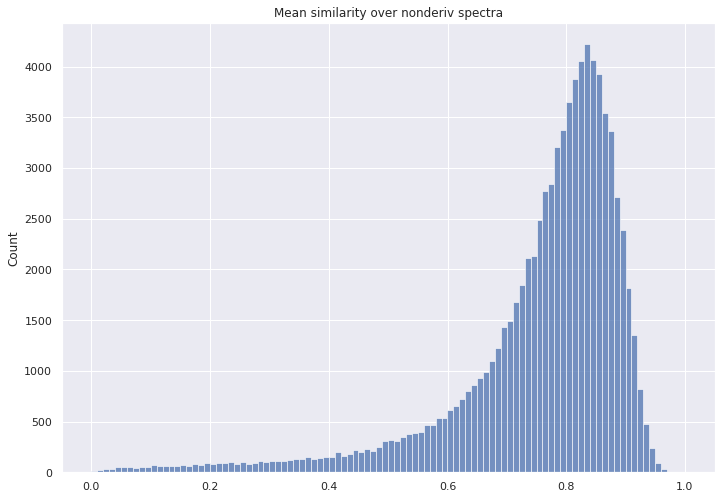

In [46]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
histplot = sns.histplot(df_nonderiv.simils.to_numpy(dtype=float), bins=100).set_title("Mean similarity over nonderiv spectra")
fig = histplot.get_figure()

### Derivatized spectra

In [47]:
# mean similarity over deriv spectra
df_deriv = df_all[df_all.isder == True]
print(f"mean similarity over nonderiv spectra is: {df_deriv.simils.mean()}")
print(f"mean SMILES len over all spectra is: {df_deriv.smiles.str.len().mean()}")
print(f"mean matched peaks over all spectra is: {df_deriv.matched_peaks.mean()}")

mean similarity over nonderiv spectra is: 0.7761414304705092
mean SMILES len over all spectra is: 49.30764563106796
mean matched peaks over all spectra is: 124.1435072815534


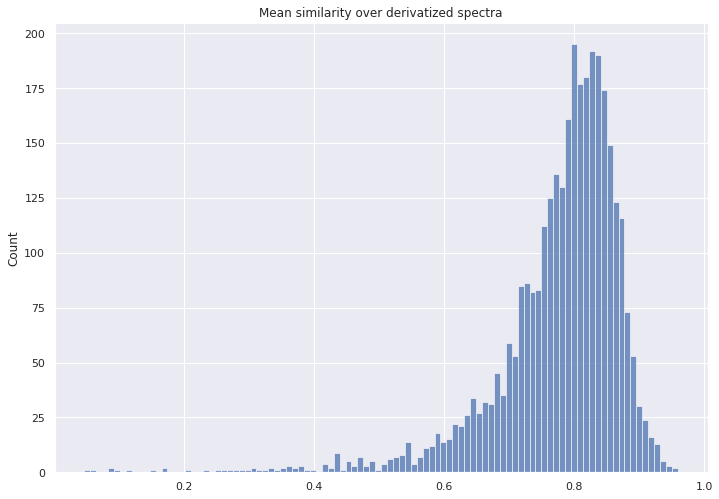

In [48]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
histplot = sns.histplot(df_deriv.simils.to_numpy(dtype=float), bins=100).set_title("Mean similarity over derivatized spectra")
fig = histplot.get_figure()

## Show pair of corresponding spectra

In [49]:
def show_spectra_pair(row, nist_spec_tag="NIST_spec", neims_spec_tag="NEIMS_spec"):
    """take a df row (returned by df.iloc[n]) and plot a mirrored graph of the two corresponding spektra"""
    row[nist_spec_tag].plot_against(row[neims_spec_tag])
    plt.xlim(0, 200)
    plt.title(f"Spectrum comparison, similarity: {row.simils.round(3)}")
    plt.legend(["NIST", "NEIMS"], labelcolor=["mediumblue","teal"], loc='upper right', bbox_to_anchor=(1, 0.9))

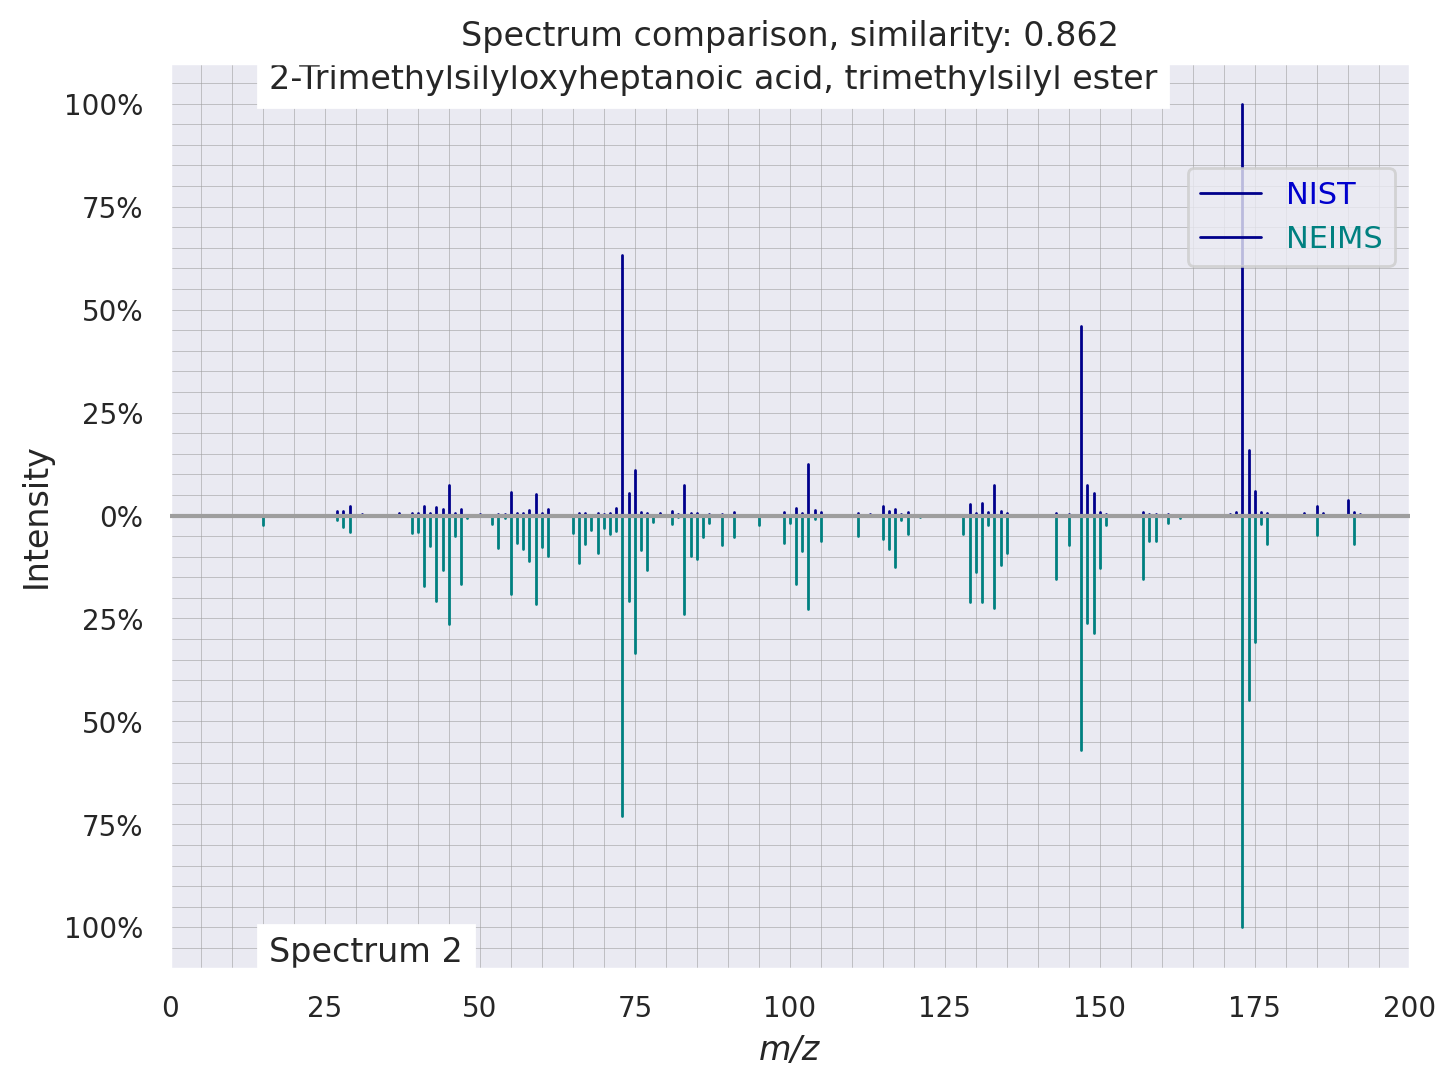

In [50]:
show_spectra_pair(df_deriv.iloc[1000])

## Save DataFrames
The spectra are only string placeholders. The real spectra are stored separately in the **NIST20_only{_NEIMS}.msp**

In [51]:
df_all.drop(columns=["ROMol"]).to_csv("data/NIST/NIST_20only/df_all.csv")